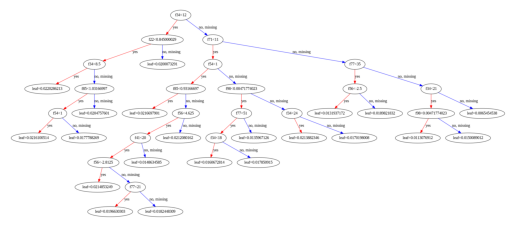

In [68]:
import pandas as pd
import numpy as np
import functions as fn
# from functions import load_xgb_model
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

model_path = '../models/'
path = '../processed/'
sfx = '_final_subm'

bst1 = fn.load_xgb_model(model_path+'bst1_1'+sfx)
plot_tree(bst1)
plt.savefig("temp.pdf")
plt.show()

<Axes: >

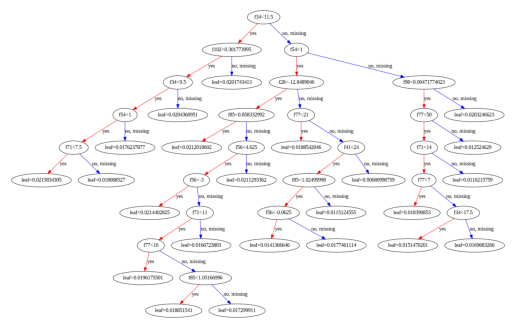

In [69]:
plot_tree(bst1, num_trees=3)

In [70]:
def num2i64(x):
    if x>=0:
        sgn = "true"
    else:
        sgn = "false"
    return f"i64{{sgn:{sgn}, v: {abs(x)}}}"

In [119]:
def num2i64_field(x):
    if x>=0:
        sgn = 1
    else:
        sgn = 0
    return f'{sgn}", "{abs(x)}'

In [120]:
def num2i64input(x):
    if x>=0:
        sgn = "true"
    else:
        sgn = "false"
    return f'{{"sgn":{sgn}, "v": "{abs(x)}"}}'

In [121]:
def test_col2i64_list_of_field(test_col):
    instr = '"'
    for i in test_col:
       # instr+= f'"{int(np.round(i*10000000000,0))}", '
        instr+=num2i64_field(int(np.round(i*10000000000,0)))
        instr+='", "'
    instr = instr[:-3]
    return instr

In [122]:
def test_col2i64(test_col):
    instr = '['
    for i in test_col:
       # instr+= f'"{int(np.round(i*10000000000,0))}", '
        instr+=num2i64input(int(np.round(i*10000000000,0)))
        instr+=', '
    instr = instr[:-2]+']'
    return instr

In [123]:
def get_feature_names_instr_1():
    test, integer_labels, actual_labels, integer_labels_full = fn.load_test_data(path,1,1)
    test = test.loc[:,test.mean() != -99999]
    feature_names = list(test.columns.to_numpy())
    instr = test_col2i64_list_of_field(test.iloc[1])
    return feature_names, instr

In [124]:
def get_feature_names_instr_2():
    test, integer_labels, actual_labels, integer_labels_full = fn.load_test_data(path,1,4)
    feature_names = list(test.columns.to_numpy())
    instr = test_col2i64_list_of_field(test.iloc[1])
    return feature_names, instr

In [125]:
def get_feature_names_instr_3():
    test, integer_labels, actual_labels, integer_labels_full = fn.load_test_data(path,3,8)
    feature_names = list(test.columns.to_numpy())
    instr = test_col2i64_list_of_field(test.iloc[1])
    return feature_names, instr

In [135]:
def get_feature_names_instr_4(use_xtra_features = True):
    test, integer_labels, actual_labels, integer_labels_full = fn.load_test_data(path,7,18)

    if use_xtra_features:
        types = ['TimeToEnd','Reflectivity','Zdr','RR2','ReflectivityQC','RadarQualityIndex','RR3','RR1','Composite','RhoHV','HybridScan','LogWaterVolume']
        xtra_test = pd.DataFrame()
        for i in range(len(types)):
            xtra_test_temp = pd.read_csv(path+'test_'+types[i]+'8_17.csv',index_col=0)
            xtra_test = pd.concat([xtra_test,xtra_test_temp],axis=1)

        xtra_test = xtra_test.reindex(test.index)
        test= pd.concat([test, xtra_test],axis=1)
    feature_names = list(test.columns.to_numpy())
    instr = test_col2i64_list_of_field(test.iloc[1])
    return feature_names, instr

In [136]:
def get_feature_names_instr_5(use_xtra_features = True):
    test, integer_labels, actual_labels, integer_labels_full = fn.load_test_data(path,17,1000)

    if use_xtra_features:
        types = ['TimeToEnd','Reflectivity','Zdr','RR2','ReflectivityQC','RadarQualityIndex','RR3','RR1','Composite','RhoHV','HybridScan','LogWaterVolume']
        xtra_test = pd.DataFrame()
        for i in range(len(types)):
            xtra_test_temp = pd.read_csv(path+'test_'+types[i]+'18_199.csv',index_col=0)
            xtra_test = pd.concat([xtra_test,xtra_test_temp],axis=1)

        xtra_test = xtra_test.reindex(test.index)
        test= pd.concat([test, xtra_test],axis=1)

    feature_names = list(test.columns.to_numpy())
    instr = test_col2i64_list_of_field(test.iloc[1])
    return feature_names, instr

In [143]:
def get_feature_names_instr(i, use_xtra_features):
    if i == 1:
        return get_feature_names_instr_1()
    elif i == 2:
        return get_feature_names_instr_2()
    elif i == 3:
        return get_feature_names_instr_3()
    elif i == 4:
        return get_feature_names_instr_4(use_xtra_features)
    elif i == 5:
        return get_feature_names_instr_5(use_xtra_features)
    else:
        print("Try to get features out of the scope.")

In [144]:
def feature_names2fformat(feature_names):
    f_names = list(range(len(feature_names)))
    f_names = list(map(str, f_names))
    return f_names

In [145]:
import json

def parse_tree_dump(dump):
    # Parse the JSON formatted string of XGBoost model dump.
    tree_structure = json.loads(dump)
    return tree_structure

In [146]:
def recurse(tree, feature_names, depth):
    indent = "    " * depth
    # Base case: if this is a leaf node, return the leaf value
    if 'leaf' in tree:
        return f"{indent} {num2i64(int(np.round(tree['leaf']*10000000000,0)))}\n"

    # Otherwise, this is a split node, so get the split condition
    split_name = feature_names[int(tree['split'][1:])]  # assumes 'fXX' format and gets the feature name
    threshold = tree['split_condition']
    if depth == 1:
        result = f"{indent}x = if i64_le(f[{split_name}], {num2i64(int(np.round(threshold*10000000000,0)))}) {{\n"
    else:
        result = f"{indent}if i64_le(f[{split_name}], {num2i64(int(np.round(threshold*10000000000,0)))}){{\n"
    # result = f"{indent}if {split_name} <= {threshold} then\n"

    # Recurse on the 'yes' branch (the left subtree)
    yes_branch = tree['children'][0]  # The first child is always the 'yes' branch
    result += recurse(yes_branch, feature_names, depth + 1)
    result += f"{indent} }}\n"

    # Add the 'else' branch (the right subtree)
    result += f"{indent}else {{\n"
    no_branch = tree['children'][1]  # The second child is always the 'no' branch
    result += recurse(no_branch, feature_names, depth + 1)

    if depth == 1:
        result += f"{indent} }};\n"
        result += f"{indent} y = i64_add(y, x);\n"
    else:
        result += f"{indent} }}\n"

    # Return the full if-else block for this node
    return result

In [147]:
# def recurse(node, depth):
#     indent = "    " * depth
#     if tree_.feature[node] != _tree.TREE_UNDEFINED:
#         name = feature_name[node].replace(" ", "_")[:-5]
#         threshold = tree_.threshold[node]
#         if depth == 1:
#             print("{}return if {} <= {} {{".format(indent, name, int(np.round(threshold*100,0))))
#         else:
#             print("{}if {} <= {} {{".format(indent, name, int(np.round(threshold*100,0))))
#         recurse(tree_.children_left[node], depth + 1)
#         print("{} }}".format(indent))
#         print("{}else {{".format(indent, name, int(np.round(threshold*100,0))))
#         recurse(tree_.children_right[node], depth + 1)
#         if depth == 1:
#             print("{} }};".format(indent))
#         else:
#             print("{} }}".format(indent))
#     else:
#         print("{} {}".format(indent, np.argmax(tree_.value[node][0])))
# # recurse(0, 1)
# # print("}")

In [148]:
def xgb_to_zokrates(booster, feature_names, nt_limit):
    trees_dump = booster.get_dump(dump_format='json')
    # first_tree_structure = json.loads(trees_dump[0])
    # print(json.dumps(first_tree_structure, indent=2))
    code_string = """
    struct i64{
        bool sgn;
        u64 v;
    }
    
    def i64_le(i64 lth, i64 rth) -> bool{
        return if lth.sgn == true {
            if rth.sgn == true {
                lth.v <= rth.v
            }else{
                false
            }
        }else{
            if rth.sgn == true{
                true
            }else{
                lth.v > rth.v
            }
        };
    }
    
    def i64_add(i64 lth, i64 rth) -> i64{
        return if lth.sgn == rth.sgn {
            i64{sgn:lth.sgn, v: (lth.v + rth.v)}
        }else{
            if lth.v == rth.v {
                i64{sgn:true, v: 0}
            }else{
                if lth.v < rth.v {
                    i64{sgn:rth.sgn, v: (rth.v - lth.v)}
                }else{
                    i64{sgn:lth.sgn, v: (lth.v - rth.v)}
                }
            }
        };
    }
    """
    # Print the ZoKrates function signature
    str_zok = "" + code_string
    str_zok +="def main(private i64[{}] f) -> i64 {{\n".format(len(feature_names))
    str_zok +="    i64 mut y = i64{sgn:true, v: 0};\n"
    str_zok +="    i64 mut x = i64{sgn:true, v: 0};\n"

    # Translate each tree
    for tree_idx, tree_dump in enumerate(trees_dump):
        if tree_idx>=nt_limit: break
        tree_structure = json.loads(tree_dump)  # directly parse the JSON string
        str_zok +="  // Tree {}\n".format(tree_idx)
        str_zok += recurse(tree_structure, feature_names, 1) + "\n"
        str_zok += "\n"  # New line for readability between trees

    str_zok += "    return y;\n"

    # Close the function
    str_zok += "}\n"
    return str_zok

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

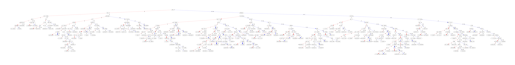

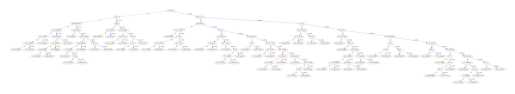

In [151]:
for i in range(3, 5):
    use_xtra_features = False
    feature_names, instr = get_feature_names_instr(i+1, use_xtra_features)
    with open(f"bst{i+1}_feature_names.txt", "w") as text_file:
        text_file.write(f"{feature_names}")
    with open(f"bst{i+1}_instr.txt", "w") as text_file:
        text_file.write(instr)
    
    f_names = feature_names2fformat(feature_names)
    print(f_names)
    if use_xtra_features:
        bst = fn.load_xgb_model(model_path+f'bst{i+1}_1'+sfx)
    else:
        bst = fn.load_xgb_model(model_path+f'bst{i+1}_1'+sfx+'_no_xtra_features')
    plot_tree(bst)
    nt_limit_list = [10, 20, 50, 100, 150, 200, 250, 300]
    for j in nt_limit_list:
        str_zok = xgb_to_zokrates(bst, f_names, j)
        with open(f"bst{i+1}_{j}_no_use_xtra_features.zok", "w") as text_file:
            text_file.write(str_zok)

In [15]:
nt_limit = 2
import functions as fn

In [16]:
predictions1 = fn.make_prediction1(fn.load_xgb_model(model_path+'bst1_1'+sfx),nt_limit,path)

[[     0. -99999. -99999. ...      0.      0.      0.]
 [     0. -99999. -99999. ...      0.      0.      0.]
 [     0. -99999. -99999. ...      0.      0.      0.]
 ...
 [     0. -99999. -99999. ...      0.      0.      0.]
 [     0. -99999. -99999. ...      0.      0.      0.]
 [     0. -99999. -99999. ...      0.      0.      0.]]
           0         1         2
Id                              
2   0.348056  0.326055  0.325889


In [17]:
for i, tree in enumerate(bst1.get_dump()):
    if i>2:
        break
    print(tree)  # This prints the tree structure

0:[f34<12] yes=1,no=2,missing=2
	1:[f22<0.845000029] yes=3,no=4,missing=4
		3:[f34<8.5] yes=7,no=8,missing=8
			7:leaf=0.0220286213
			8:[f85<1.03166997] yes=13,no=14,missing=14
				13:[f54<1] yes=23,no=24,missing=24
					23:leaf=0.0216100514
					24:leaf=0.0177788269
				14:leaf=0.0204757601
		4:leaf=0.0200073291
	2:[f71<11] yes=5,no=6,missing=6
		5:[f54<1] yes=9,no=10,missing=10
			9:[f85<0.93166697] yes=15,no=16,missing=16
				15:leaf=0.0216697901
				16:[f56<4.625] yes=25,no=26,missing=26
					25:[f41<20] yes=33,no=34,missing=34
						33:[f56<-2.8125] yes=37,no=38,missing=38
							37:leaf=0.0214853249
							38:[f77<21] yes=39,no=40,missing=40
								39:leaf=0.0196630303
								40:leaf=0.0182448309
						34:leaf=0.0148634585
					26:leaf=0.0212080162
			10:[f98<0.00471774023] yes=17,no=18,missing=18
				17:[f77<51] yes=27,no=28,missing=28
					27:[f34<18] yes=35,no=36,missing=36
						35:leaf=0.0160672814
						36:leaf=0.017850915
					28:leaf=0.0135967126
				18:[f34<24] yes=29

In [18]:
# Function to parse the tree and extract thresholds
def parse_tree(tree):
    for line in tree.split('\n'):
        if '<' in line:  # Check if the line contains a decision rule
            # Extract feature index and threshold
            parts = line.split('[')[1].split(']')[0].split('<')
            feature_index = int(parts[0][1:])  # Convert 'fXX' to an integer
            threshold = float(parts[1])
            yield feature_index, threshold

In [19]:
for i, tree in enumerate(bst1.get_dump()):
    if i>0:
        break
    for feature_index, threshold in parse_tree(tree):
        print(test.loc[2][feature_index],threshold)   # Or <=, depending on your requirement

6.0 12.0
-99999.0 0.845000029
6.0 8.5
1.05167 1.03166997
0.0 1.0
-99999.0 11.0
0.0 1.0
1.05167 0.93166697
5.0 4.625
-99999.0 20.0
5.0 -2.8125
54.0 21.0
-99999.0 0.00471774023
54.0 51.0
6.0 18.0
6.0 24.0
54.0 35.0
5.0 -2.5
6.0 21.0
-99999.0 0.00471774023


/tmp/ipykernel_467/1363360951.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(test.loc[2][feature_index],threshold)   # Or <=, depending on your requirement


In [20]:
import re

# Assuming you have an XGBoost model named 'model'
# model = xgb.XGBClassifier().fit(X_train, y_train)

# Access the Booster and get the tree dump
trees = bst1.get_dump()

# Function to parse a single tree
def parse_tree(tree):
    layers = {}
    for line in tree.split('\n'):
        if line.strip():
            depth = line.count('\t')
            is_leaf = 'leaf' in line
            if is_leaf:
                # Extract leaf value
                value = float(re.search(r'leaf=(.*)', line).group(1))
                info = ('leaf', value)
            else:
                # Extract feature and threshold
                parts = re.search(r'\[(f\d+)<(.+)\]', line).groups()
                feature = parts[0]
                threshold = float(parts[1])
                info = (feature, threshold)
            
            if depth not in layers:
                layers[depth] = []
            layers[depth].append(info)
    return layers

# Parse each tree and print layer-wise information
for tree_index, tree in enumerate(trees):
    if tree_index>1:
        break
    print(f"Tree {tree_index + 1}")
    layers = parse_tree(tree)
    for layer in sorted(layers):
        print(f"  Layer {layer}:")
        for node in layers[layer]:
            if node[0] == 'leaf':
                print(f"    Leaf node with value: {node[1]}")
            else:
                print(f"    Decision node on feature {node[0]} with threshold {node[1]}")


Tree 1
  Layer 0:
    Decision node on feature f34 with threshold 12.0
  Layer 1:
    Decision node on feature f22 with threshold 0.845000029
    Decision node on feature f71 with threshold 11.0
  Layer 2:
    Decision node on feature f34 with threshold 8.5
    Leaf node with value: 0.0200073291
    Decision node on feature f54 with threshold 1.0
    Decision node on feature f77 with threshold 35.0
  Layer 3:
    Leaf node with value: 0.0220286213
    Decision node on feature f85 with threshold 1.03166997
    Decision node on feature f85 with threshold 0.93166697
    Decision node on feature f98 with threshold 0.00471774023
    Decision node on feature f56 with threshold -2.5
    Decision node on feature f34 with threshold 21.0
  Layer 4:
    Decision node on feature f54 with threshold 1.0
    Leaf node with value: 0.0204757601
    Leaf node with value: 0.0216697901
    Decision node on feature f56 with threshold 4.625
    Decision node on feature f77 with threshold 51.0
    Decision n

In [21]:
import re

# Assuming you have an XGBoost model named 'model'
# model = xgb.XGBClassifier().fit(X_train, y_train)

# Access the Booster and get the tree dump
trees = bst1.get_dump()

MAX_LAYERS = 9
PLACEHOLDER = "N/A"  # Placeholder for vacant positions

# Function to parse and standardize a single tree to 9 layers
def standardize_tree(tree):
    layers = {i: [] for i in range(MAX_LAYERS)}
    for line in tree.split('\n'):
        if line.strip():
            depth = line.count('\t')
            is_leaf = 'leaf' in line
            if is_leaf:
                value = float(re.search(r'leaf=(.*)', line).group(1))
                info = ('leaf', value)
            else:
                parts = re.search(r'\[(f\d+)<(.+)\]', line).groups()
                feature = parts[0]
                threshold = float(parts[1])
                info = (feature, threshold)

            layers[depth].append(info)

    # Fill in missing layers with placeholders
    for layer in layers:
        if not layers[layer]:
            layers[layer].append((PLACEHOLDER, PLACEHOLDER))

    return layers

# Parse each tree and print standardized layers
for tree_index, tree in enumerate(trees):
    if tree_index>1:
        break
    print(f"\nTree {tree_index + 1}")
    layers = standardize_tree(tree)
    for layer in range(MAX_LAYERS):
        print(f"  Layer {layer}:")
        for node in layers[layer]:
            if node[0] == 'leaf':
                print(f"    Leaf node with value: {node[1]}")
            elif node[0] == PLACEHOLDER:
                print(f"    {PLACEHOLDER}")
            else:
                print(f"    Decision node on feature {node[0]} with threshold {node[1]}")



Tree 1
  Layer 0:
    Decision node on feature f34 with threshold 12.0
  Layer 1:
    Decision node on feature f22 with threshold 0.845000029
    Decision node on feature f71 with threshold 11.0
  Layer 2:
    Decision node on feature f34 with threshold 8.5
    Leaf node with value: 0.0200073291
    Decision node on feature f54 with threshold 1.0
    Decision node on feature f77 with threshold 35.0
  Layer 3:
    Leaf node with value: 0.0220286213
    Decision node on feature f85 with threshold 1.03166997
    Decision node on feature f85 with threshold 0.93166697
    Decision node on feature f98 with threshold 0.00471774023
    Decision node on feature f56 with threshold -2.5
    Decision node on feature f34 with threshold 21.0
  Layer 4:
    Decision node on feature f54 with threshold 1.0
    Leaf node with value: 0.0204757601
    Leaf node with value: 0.0216697901
    Decision node on feature f56 with threshold 4.625
    Decision node on feature f77 with threshold 51.0
    Decision 

In [22]:
def complement_tree_to_9_layers(node, current_depth=0, target_depth=9, ancestor_leaf_value=None):
    """
    Recursively complements a binary tree to the specified depth using ancestor leaf values.
    If a node did not exist, it is created using the value of its ancestor leaf node.
    """
    if current_depth == target_depth:
        return node

    # If the node is a leaf, store its value for descendants and extend the tree further
    if 'leaf' in node:
        new_leaf_value = node['leaf']
    else:
        new_leaf_value = ancestor_leaf_value

    # Replace the leaf node with a non-leaf node that leads to two new leaf nodes with ancestor leaf value
    if 'leaf' in node or 'children' not in node:
        new_node = {
            "nodeid": node.get("nodeid", 0),
            "depth": current_depth,
            "split": 0,  # Dummy split feature
            "split_condition": 0,  # Dummy split condition
            "yes": (node.get("nodeid", 0) * 2 + 1),  # Generating unique IDs for children
            "no": (node.get("nodeid", 0) * 2 + 2),
            "missing": (node.get("nodeid", 0) * 2 + 1),
            "children": [
                {"nodeid": (node.get("nodeid", 0) * 2 + 1), "depth": current_depth + 1, "leaf": new_leaf_value},
                {"nodeid": (node.get("nodeid", 0) * 2 + 2), "depth": current_depth + 1, "leaf": new_leaf_value}
            ]
        }
        return new_node

    # If the node is not a leaf, process its children
    node["children"] = [complement_tree_to_9_layers(child, current_depth + 1, target_depth, new_leaf_value) for child in node["children"]]
    return node

# Process all trees in the model
complemented_trees = [complement_tree_to_9_layers(json.loads(t), ancestor_leaf_value=0) for t in bst1.get_dump(dump_format='json')]

# Displaying the first tree for brevity
complemented_tree_json = json.dumps(complemented_trees[0], indent=2)
print(complemented_tree_json)  # Displaying
len(complemented_tree_json)  # Checking the length of the JSON string to understand its size


{
  "nodeid": 0,
  "depth": 0,
  "split": "f34",
  "split_condition": 12,
  "yes": 1,
  "no": 2,
  "missing": 2,
  "children": [
    {
      "nodeid": 1,
      "depth": 1,
      "split": "f22",
      "split_condition": 0.845000029,
      "yes": 3,
      "no": 4,
      "missing": 4,
      "children": [
        {
          "nodeid": 3,
          "depth": 2,
          "split": "f34",
          "split_condition": 8.5,
          "yes": 7,
          "no": 8,
          "missing": 8,
          "children": [
            {
              "nodeid": 7,
              "depth": 3,
              "split": 0,
              "split_condition": 0,
              "yes": 15,
              "no": 16,
              "missing": 15,
              "children": [
                {
                  "nodeid": 15,
                  "depth": 4,
                  "leaf": 0.0220286213
                },
                {
                  "nodeid": 16,
                  "depth": 4,
                  "leaf": 0.0220286213
   

20704

In [23]:
def print_tree_sorted_by_nodeID(node, current_depth=0, max_depth=9, nodes_info=None):
    """
    Collects and prints the tree information sorted by nodeID, displaying splits, split conditions,
    and leaf node values.
    """
    if nodes_info is None:
        nodes_info = []

    # Base case for recursion: If max depth is reached or node is a leaf, return
    # if current_depth > max_depth or 'leaf' in node:
    #     return
    if current_depth > max_depth:
        return

    # Collect current node details
    node_info = {
        "nodeid": node.get("nodeid"),
        "depth": current_depth,
        "split": node.get("split"),
        "split_condition": node.get("split_condition"),
        "leaf_value": node.get("leaf")
    }
    nodes_info.append(node_info)

    # Recurse on children
    if 'children' in node:
        for child in node['children']:
            print_tree_sorted_by_nodeID(child, current_depth + 1, max_depth, nodes_info)

    # Print information sorted by nodeID at the end of recursion
    if current_depth == 0:
        sorted_info = sorted(nodes_info, key=lambda x: x["nodeid"])
        for info in sorted_info:
            if info["leaf_value"] is not None:
                # print(f"NodeID {info['nodeid']} (Depth {info['depth']}): Leaf Value {info['leaf_value']}")
                # print(f"Field({info['leaf_value']}),")
                leaf_list.append(info['leaf_value'])
            else:
                # print(f"NodeID {info['nodeid']} (Depth {info['depth']}): Split {info['split']}, Split Condition {info['split_condition']}")
                if info['split'] == 0:
                    test_list.append(0)
                    split_condition.append(0)
                else:
                    feature_index = int(info['split'][1:]) 
                    # print(test.loc[2][feature_index],info['split_condition'])
                    test_list.append(test.loc[2][feature_index])
                    split_condition.append(info['split_condition'])

# Print the first tree, sorted by nodeID
leaf_list = []
test_list = []
split_condition = []
print_tree_sorted_by_nodeID(complemented_trees[0])


/tmp/ipykernel_467/3216545836.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_list.append(test.loc[2][feature_index])


In [24]:
s_leaf = "), Field(".join([str(int(i*10**8)) for i in leaf_list])
s_leaf = "[Field("+s_leaf
s_leaf = s_leaf + ")]"

In [25]:
print(s_leaf)

[Field(2000732), Field(2000732), Field(2202862), Field(2202862), Field(2047576), Field(2047576), Field(2166979), Field(2166979), Field(1319371), Field(1319371), Field(1898218), Field(1898218), Field(654545), Field(654545), Field(2161005), Field(2161005), Field(1777882), Field(1777882), Field(2120801), Field(2120801), Field(1359671), Field(1359671), Field(2138823), Field(2138823), Field(1701980), Field(1701980), Field(1130769), Field(1130769), Field(1500890), Field(1500890), Field(1486345), Field(1486345), Field(1606728), Field(1606728), Field(1785091), Field(1785091), Field(2148532), Field(2148532), Field(1966303), Field(1966303), Field(1824483), Field(1824483)]


In [26]:
s_test = "), Field(".join([str(int(i*10**8)) for i in test_list])
s_test = "[Field("+s_test
s_test = s_test + ")]"

In [27]:
print(s_test)

[Field(600000000), Field(-9999900000000), Field(-9999900000000), Field(600000000), Field(0), Field(0), Field(5400000000), Field(0), Field(105167000), Field(105167000), Field(-9999900000000), Field(500000000), Field(600000000), Field(0), Field(0), Field(0), Field(500000000), Field(5400000000), Field(600000000), Field(0), Field(0), Field(-9999900000000), Field(0), Field(0), Field(0), Field(-9999900000000), Field(0), Field(600000000), Field(0), Field(0), Field(0), Field(0), Field(0), Field(500000000), Field(0), Field(0), Field(0), Field(0), Field(5400000000), Field(0), Field(0)]


In [28]:
s_split_condition = "), Field(".join([str(int(i*10**8)) for i in split_condition])
s_split_condition = "[Field("+s_split_condition
s_split_condition = s_split_condition + ")]"

In [29]:
print(s_split_condition)

[Field(1200000000), Field(84500002), Field(1100000000), Field(850000000), Field(0), Field(100000000), Field(3500000000), Field(0), Field(103166997), Field(93166697), Field(471774), Field(-250000000), Field(2100000000), Field(100000000), Field(0), Field(0), Field(462500000), Field(5100000000), Field(2400000000), Field(0), Field(0), Field(471774), Field(0), Field(0), Field(0), Field(2000000000), Field(0), Field(1800000000), Field(0), Field(0), Field(0), Field(0), Field(0), Field(-281250000), Field(0), Field(0), Field(0), Field(0), Field(2100000000), Field(0), Field(0)]


In [31]:
print(len(s_split_condition))

573


In [33]:
print(len(s_leaf))

670


In [34]:
print(len(s_test))

582
